In [ ]:
# notebook imports

import math
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img

In [ ]:
# make model call backs

save_path = 'model_experiments'

def create_model_checkpoint(model_name, save_path=save_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0, 
                                              save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=50,
                                                  restore_best_weights=True)

reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      patience=500,
                                                      verbose=1)

In [ ]:
# helper functions
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get data

# face_data2 = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/face_expression/face_expression.zip'
# unzip_data(face_data2)
# /content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data


train_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/validation'

In [ ]:
import os
from PIL import Image
folder_path = validation_dir
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [ ]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data")

There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data'.
There are 5 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train'.
There are 0 directories and 39 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/cercospora_leaf_spot'.
There are 0 directories and 37 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/anthracnose'.
There are 0 directories and 42 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/phosphorus_deficiency'.
There are 0 directories and 42 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/rice_brown_leaf_spot'.
There are 0 directories and 50 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/sunflower_leaf_blight'.
There are 5 directories and 0 images in '/content

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['anthracnose' 'cercospora_leaf_spot' 'phosphorus_deficiency'
 'rice_brown_leaf_spot' 'sunflower_leaf_blight']


In [ ]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


# Model 0

In [ ]:
# creat model: Base model

num_classes = len(class_names)

# Create a CNN model
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_0')

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [ ]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_0.name), early_stopping, reduce_plateau]

history_0 = model_0.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/20
2/2 [==============================] - 76s 50s/step - loss: 1.6220 - accuracy: 0.2714 - val_loss: 1.5695 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 28s 17s/step - loss: 1.5115 - accuracy: 0.4571 - val_loss: 1.5442 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 27s 16s/step - loss: 1.4013 - accuracy: 0.4714 - val_loss: 1.4296 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 27s 15s/step - loss: 1.3230 - accuracy: 0.5429 - val_loss: 1.3474 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 27s 15s/step - loss: 1.1268 - accuracy: 0.6857 - val_loss: 1.2342 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 27s 15s/step - loss: 0.9812 - accuracy: 0.7238 - val_loss: 1.1769 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 27s 15s/step - loss: 0.8529 - accuracy

In [ ]:
model_0.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6885 - accuracy: 0.7069


[0.6885467767715454, 0.7068965435028076]

In [ ]:
saved_model = tf.keras.models.load_model('model_experiments/model_0/')
saved_model.evaluate(valid_data)

1/1 [==============================] - 7s 7s/step - loss: 0.6280 - accuracy: 0.8103


[0.6280130743980408, 0.8103448152542114]

In [ ]:
saved_model.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_0.h5')

In [ ]:
test_m = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_0.h5')
test_m.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6280 - accuracy: 0.8103


[0.6280130743980408, 0.8103448152542114]

In [ ]:
type(test_m)

keras.engine.sequential.Sequential

In [ ]:
c = ['abacha', 'boli', 'jellof_rice', 'suya']
cuisines = {
    'abacha': 'Abacha is a nigerian food',
    'boli': 'Boli, also know as roasted plantain',
    'jellof_rice': 'Jellof_rice is a delicious Nigerian meal',
    'suya': 'Suya is a grilled beef sold usually at night'
}

In [ ]:
# make Prediction

# Create a function to import an image and resize it to be able to be used with our model
def plot_and_pred(model, filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = f'{math.ceil(pred.max()*100)}%'
    pred_class = class_names[int(np.argmax(pred))]
    
    plt.title(f'{pred_class.title()} {prob}')
#     plt.xlabel(cuisines[pred_class])
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.squeeze(img))
    
    return pred_class

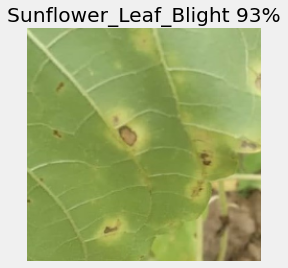

In [ ]:
# plt.figure(figsize=(5, 5))
p = plot_and_pred(test_m, 'test5.jpg')

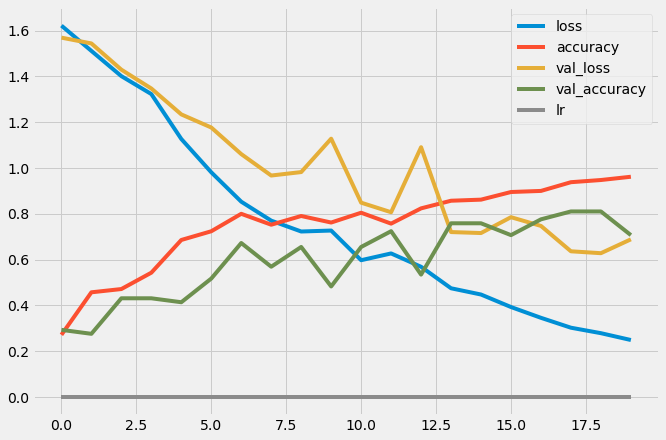

In [ ]:
pd.DataFrame(history_0.history).plot(figsize=(10, 7))

In [ ]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    
    return img

sample_image = load_and_prep_image("61.jpg")
pred = model_0.predict(sample_image)
prob = math.ceil(pred.max()*100)
pred_class = class_names[int(np.argmax(pred))]
print(f'Prediction: {pred_class} \nConf: {prob}%')

Prediction: jellof_rice 
Conf: 100%


# Model 1
## same model as model 0, but with data augmentation

In [ ]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


In [ ]:
# create model: model 1

num_classes = len(class_names)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_1')

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [ ]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_1.name), early_stopping, reduce_plateau]

history_1 = model_1.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/20
2/2 [==============================] - 35s 21s/step - loss: 1.6190 - accuracy: 0.2810 - val_loss: 1.5716 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 28s 16s/step - loss: 1.5332 - accuracy: 0.4190 - val_loss: 1.5520 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 30s 17s/step - loss: 1.4444 - accuracy: 0.4619 - val_loss: 1.4382 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 28s 15s/step - loss: 1.4176 - accuracy: 0.4524 - val_loss: 1.3525 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 28s 15s/step - loss: 1.2670 - accuracy: 0.5476 - val_loss: 1.2815 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 28s 15s/step - loss: 1.1809 - accuracy: 0.5857 - val_loss: 1.2799 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 28s 15s/step - loss: 1.1023 - accuracy

In [ ]:
model_1.evaluate(valid_data)

1/1 [==============================] - 12s 12s/step - loss: 0.6105 - accuracy: 0.7931


[0.6105399131774902, 0.7931034564971924]

In [ ]:
saved_model_1 = tf.keras.models.load_model('model_experiments/model_1/')
saved_model_1.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6105 - accuracy: 0.7931


[0.6105399131774902, 0.7931034564971924]

In [ ]:
model_1.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_1.h5')

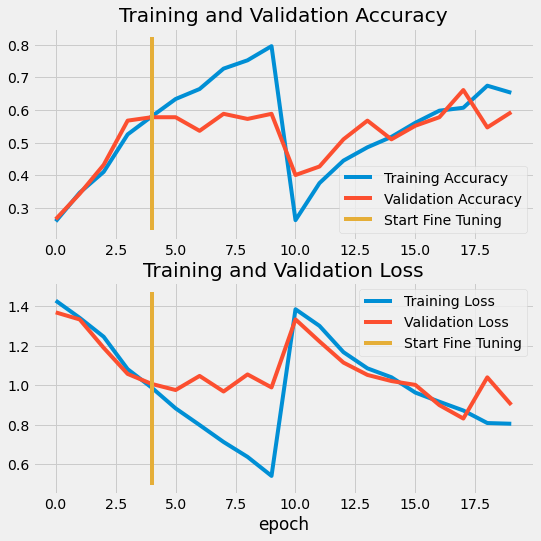

In [ ]:
compare_historys(history_0, history_1)

# Model 2
## same model as model 1, but with full dataset

In [ ]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


In [ ]:
# create model: model 2

num_classes = len(class_names)

# Create a CNN model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_2')

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [ ]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_2.name), early_stopping, reduce_plateau]

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/5
2/2 [==============================] - 35s 21s/step - loss: 1.6190 - accuracy: 0.2810 - val_loss: 1.5716 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - 30s 16s/step - loss: 1.5332 - accuracy: 0.4190 - val_loss: 1.5520 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 3/5
2/2 [==============================] - 28s 16s/step - loss: 1.4444 - accuracy: 0.4619 - val_loss: 1.4382 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 4/5
2/2 [==============================] - 29s 20s/step - loss: 1.3121 - accuracy: 0.5095 - val_loss: 1.6590 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 5/5
2/2 [==============================] - 28s 21s/step - loss: 1.3036 - accuracy: 0.5190 - val_loss: 1.4064 - val_accuracy: 0.2931 - lr: 0.0010
CPU times: user 2min 36s, sys: 2.58 s, total: 2min 38s
Wall time: 2min 41s


In [ ]:
model_2.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 1.4064 - accuracy: 0.2931


[1.4064215421676636, 0.2931034564971924]

<AxesSubplot:>

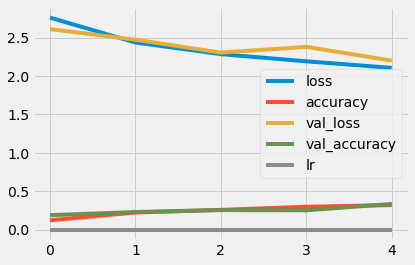

In [ ]:
pd.DataFrame(history_2.history).plot()

In [ ]:
model_2.evaluate(valid_data)

5/5 [==============================] - 78s 15s/step - loss: 2.1997 - accuracy: 0.3360


[2.1997134685516357, 0.3360389471054077]

In [ ]:
saved_model = tf.keras.models.load_model('model_experiments/model_2/')
saved_model.evaluate(valid_data)

5/5 [==============================] - 64s 12s/step - loss: 2.1997 - accuracy: 0.3360


[2.199713706970215, 0.3360389471054077]

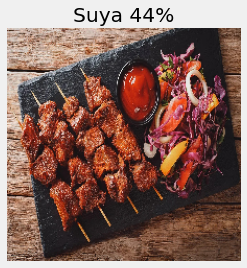

In [ ]:
p = plot_and_pred(model_2, '58.jpg')
cuisines[p]

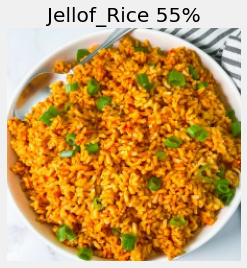

In [ ]:
p = plot_and_pred(model_2, '25.jpg')
# cuisines[p]

In [ ]:
class_names = ['abacha', 'akara', 'jellof_rice', 'moin_moin', 'pounded_yam', 'suya']

def plot_and_pred(model, filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = f'{math.ceil(pred.max()*100)}%'
    pred_class = class_names[int(np.argmax(pred))]
    
    plt.title(f'{pred_class.title()} {prob}')
#     plt.xlabel(cuisines[pred_class])
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.squeeze(img))
    
    return pred_class

In [ ]:
model = tf.keras.models.load_model('saved_models/model_0.h5')
model_0_saved = tf.keras.models.load_model('saved_models/model_0_saved.h5')